# Facebook Prophet Forecasting

In [1]:
% pylab inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
import pickle
from fbprophet import Prophet

pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [24]:
# Load data set
df = pickle.load(open('df.pkl','rb'))
print(df.head())

            date_block_num  shop_id  item_id  item_price  item_cnt_day
date                                                                  
2013-01-01               0       18     5823     2500.00          1.00
2013-01-01               0       46     1830      599.00          3.00
2013-01-01               0       14     1830      599.00          2.00
2013-01-01               0       14     1905      249.00          1.00
2013-01-01               0       14     2808      999.00          2.00


In [3]:
# Create dataframe dictionary of top 50 best selling items
DataFrameDict = {elem : pd.DataFrame for elem in df.item_id.unique()}

last_day = pd.DataFrame(index=['2015-10-31'])

for key in DataFrameDict.keys():
    DataFrameDict[key] = df[:][df.item_id == key]
    DataFrameDict[key] = DataFrameDict[key].groupby(['date'])['item_cnt_day'].sum().sort_index()
    DataFrameDict[key] = DataFrameDict[key].reset_index()
    DataFrameDict[key].index = DataFrameDict[key]['date']
    DataFrameDict[key] = DataFrameDict[key].drop('date', axis=1)
    pd.to_datetime(DataFrameDict[key].index)    
    if '2015-10-31' in DataFrameDict[key].index:
        pass
    else: 
        DataFrameDict[key] = DataFrameDict[key].append(last_day)
    DataFrameDict[key] = DataFrameDict[key].asfreq('D').fillna(0)
    print(DataFrameDict[key].tail(1))

            item_cnt_day
date                    
2015-10-31         10.00
            item_cnt_day
2015-10-31          0.00
            item_cnt_day
date                    
2015-10-31          2.00
            item_cnt_day
date                    
2015-10-31          2.00
            item_cnt_day
date                    
2015-10-31         15.00
            item_cnt_day
date                    
2015-10-31          6.00
            item_cnt_day
2015-10-31          0.00
            item_cnt_day
date                    
2015-10-31          2.00
            item_cnt_day
date                    
2015-10-31         11.00
            item_cnt_day
date                    
2015-10-31         28.00
            item_cnt_day
2015-10-31          0.00
            item_cnt_day
2015-10-31          0.00
            item_cnt_day
date                    
2015-10-31          1.00
            item_cnt_day
2015-10-31          0.00
            item_cnt_day
date                    
2015-10-31          7.00


### Predicting future sales using Facebook Prophet

In [27]:
# Prepare the dataframe for Prophet modeling
df_train = {elem : pd.DataFrame for elem in DataFrameDict.keys()}

for key in DataFrameDict.keys():
    df_train[key] = DataFrameDict[key].loc[DataFrameDict[key].index < '2015-10-01']
    df_train[key] = df_train[key].reset_index().rename(index=str, columns={"date": "ds", "index": "ds", "item_cnt_day":'y'})

In [29]:
# Check that all items have sales information until the last day of training data. 
for key in DataFrameDict.keys():
    print(df_train[key].tail(3))

             ds    y
1000 2015-09-28 1.00
1001 2015-09-29 0.00
1002 2015-09-30 3.00
             ds    y
1000 2015-09-28 0.00
1001 2015-09-29 0.00
1002 2015-09-30 0.00
             ds    y
1000 2015-09-28 0.00
1001 2015-09-29 0.00
1002 2015-09-30 1.00
             ds    y
1000 2015-09-28 2.00
1001 2015-09-29 0.00
1002 2015-09-30 0.00
             ds    y
1000 2015-09-28 2.00
1001 2015-09-29 1.00
1002 2015-09-30 2.00
             ds    y
1000 2015-09-28 2.00
1001 2015-09-29 5.00
1002 2015-09-30 5.00
             ds    y
1000 2015-09-28 0.00
1001 2015-09-29 2.00
1002 2015-09-30 0.00
             ds    y
1000 2015-09-28 1.00
1001 2015-09-29 1.00
1002 2015-09-30 2.00
             ds    y
1000 2015-09-28 5.00
1001 2015-09-29 6.00
1002 2015-09-30 4.00
             ds     y
1000 2015-09-28 12.00
1001 2015-09-29 21.00
1002 2015-09-30 33.00
             ds    y
1000 2015-09-28 0.00
1001 2015-09-29 0.00
1002 2015-09-30 0.00
             ds    y
1000 2015-09-28 1.00
1001 2015-09-29 1.00
1002 2015

In [6]:
from sklearn.metrics import mean_squared_error, r2_score
def rms(y_test, y_pred):
    return sqrt(mean_squared_error(y_test, y_pred))

def r2(y_test, y_pred):
    return r2_score(y_test, y_pred)

Perform grid search to find the best Prophet model for each item by forecast of Sept 2015, and record forecast of Oct 2015.

In [7]:
%%time
df_prediction = {elem : pd.DataFrame for elem in DataFrameDict.keys()}
cfg_dict = {elem : pd.DataFrame for elem in DataFrameDict.keys()}

weekly_season = [True,False]
yearly_season = [True,False]
growth_rate = ['linear','logistic']

for key in df.keys():
    least_error = None
    for w in weekly_season:
        for y in yearly_season:
            for g in growth_rate:
                cfg = [w, y, g]
                if df_train[key]['y'][-120:-30].max() == 0:
                    df_train[key]['cap'] = 1
                else:
                    df_train[key]['cap'] = df_train[key]['y'][-120:-30].max()
                m_pro = Prophet(daily_seasonality=False, weekly_seasonality=w, yearly_seasonality=y, growth=g)
                m_pro.fit(df_train[key][:-30])
                m_future = m_pro.make_future_dataframe(periods=61)
                m_future['cap'] = df_train[key]['cap']
                m_future['floor'] = 0
                forecast = m_pro.predict(m_future)
                error = rms(df_train[key]['y'][-30:], forecast['yhat'][-60:-30])
                if least_error == None:
                    least_error = error
                    df_prediction[key] = forecast[['ds','yhat']].tail(31)
                    cfg_dict[key] = cfg
                elif error < least_error:
                    least_error = error
                    df_prediction[key] = forecast[['ds','yhat']].tail(31)
                    cfg_dict[key] = cfg
                else:
                    pass
    print(key, 'best rms error: %.3f' % least_error)

5823 best rms error: 2.900
1830 best rms error: 0.264
1905 best rms error: 1.653
2808 best rms error: 1.443
22088 best rms error: 2.589
2308 best rms error: 2.688
6740 best rms error: 0.827
7856 best rms error: 1.517
5822 best rms error: 5.009
17717 best rms error: 5.850
2416 best rms error: 0.600
5272 best rms error: 0.597
7894 best rms error: 1.741
1916 best rms error: 0.700
7893 best rms error: 2.315
5821 best rms error: 2.768
11373 best rms error: 13.100
11370 best rms error: 15.420
2753 best rms error: 2.349
2445 best rms error: 2.229
6457 best rms error: 1.293
6738 best rms error: 0.830
20949 best rms error: 34.269
6497 best rms error: 5.088
15044 best rms error: 0.181
16787 best rms error: 0.881
4870 best rms error: 5.903
4178 best rms error: 2.087
4181 best rms error: 2.507
7096 best rms error: 0.527
3732 best rms error: 2.128
3734 best rms error: 1.215
3329 best rms error: 0.514
3331 best rms error: 3.593
1855 best rms error: 0.316
2269 best rms error: 1.231
1495 best rms erro

In [9]:
cfg_dict

{1495: [False, False, 'logistic'],
 1830: [False, False, 'logistic'],
 1855: [False, False, 'logistic'],
 1905: [False, False, 'linear'],
 1916: [False, False, 'linear'],
 2269: [False, False, 'linear'],
 2308: [False, True, 'logistic'],
 2416: [False, False, 'linear'],
 2445: [False, False, 'linear'],
 2753: [True, True, 'linear'],
 2808: [False, False, 'logistic'],
 3329: [False, False, 'linear'],
 3331: [False, False, 'linear'],
 3340: [False, False, 'logistic'],
 3341: [False, False, 'linear'],
 3343: [False, False, 'linear'],
 3731: [False, False, 'logistic'],
 3732: [False, False, 'logistic'],
 3733: [False, False, 'linear'],
 3734: [False, False, 'linear'],
 3928: [False, False, 'logistic'],
 4178: [False, True, 'linear'],
 4181: [False, False, 'linear'],
 4870: [False, True, 'logistic'],
 5272: [False, False, 'linear'],
 5672: [False, False, 'linear'],
 5821: [False, True, 'linear'],
 5822: [False, True, 'linear'],
 5823: [True, True, 'linear'],
 6457: [False, True, 'linear'],


### Use trained model to predict September sales

In [25]:
df_hold = df.loc[df['date_block_num'] == 32].sort_index()
df_hold = df_hold.groupby(['shop_id','item_id'])['item_cnt_day'].sum().sort_index()
df_hold = df_hold.reset_index()
df_hold = df_hold.rename(index=str, columns={"item_cnt_day": "item_cnt"})
print(df_hold.head())
print(len(df_hold))

   shop_id  item_id  item_cnt
0        2     1855      1.00
1        2     2269      1.00
2        2     2308      1.00
3        2     2753      1.00
4        2     2808      1.00
1171


In [33]:
%%time
# Fit parameters into model and make predictions

FP_pred = {elem : pd.DataFrame for elem in df_train.keys()}

for key in df_train.keys():
    if df_train[key]['y'][-120:-30].max() == 0:
        df_train[key]['cap'] = 1
    else:
        df_train[key]['cap'] = df_train[key]['y'][-120:-30].max()
    m_pro = Prophet(daily_seasonality=False, weekly_seasonality=cfg_dict[key][0], 
                    yearly_seasonality=cfg_dict[key][1], growth=cfg_dict[key][2])
    m_pro.fit(df_train[key][:-30])
    m_future = m_pro.make_future_dataframe(periods=30)
    m_future['cap'] = df_train[key]['cap']
    m_future['floor'] = 0
    forecast = m_pro.predict(m_future)
    FP_pred[key] = forecast[['ds','yhat']].tail(30)

CPU times: user 2min 25s, sys: 4.47 s, total: 2min 30s
Wall time: 2min 6s


In [34]:
# Convert the dictionary of predictions into one dataframe
for key in FP_pred.keys():
    FP_pred[key]['item_id'] = key
    
FP_pred = pd.concat([df for df in FP_pred.values()], ignore_index=True)
FP_pred = pd.DataFrame(FP_pred.groupby(['item_id'])['yhat'].sum())
print(FP_pred.head())

         yhat
item_id      
1495     0.00
1830     0.00
1855     0.00
1905    64.91
1916    22.71


In [35]:
# Merge store-item weights with item count
FP_evaluate = pd.merge(df_weight, FP_pred, on='item_id')
FP_evaluate = FP_evaluate.rename(index=str, columns={"yhat": "Prediction"})
FP_evaluate.head()

,shop_id,item_id,item_cnt,weight,Prediction
0,2,2269,1.00,0.02,36.09
1,3,2269,1.00,0.02,36.09
2,5,2269,1.00,0.02,36.09
3,6,2269,1.00,0.02,36.09
4,7,2269,2.00,0.04,36.09


In [36]:
# Calculate store-item count from forecasted data
FP_evaluate['Prediction_shop'] = round(FP_evaluate['weight'] * FP_evaluate['Prediction'])
FP_evaluate = FP_evaluate.drop('item_cnt',axis=1)
print(FP_evaluate.head())

   shop_id  item_id  weight  Prediction  Prediction_shop
0        2     2269    0.02       36.09             1.00
1        3     2269    0.02       36.09             1.00
2        5     2269    0.02       36.09             1.00
3        6     2269    0.02       36.09             1.00
4        7     2269    0.04       36.09             1.00


In [37]:
FP_evaluate = pd.merge(df_hold, FP_evaluate,  how='left', left_on=['shop_id','item_id'], 
                       right_on = ['shop_id','item_id']).fillna(0)
FP_evaluate.head()

,shop_id,item_id,item_cnt,weight,Prediction,Prediction_shop
0,2,1855,1.00,0.00,0.00,0.00
1,2,2269,1.00,0.02,36.09,1.00
2,2,2308,1.00,0.01,0.00,0.00
3,2,2753,1.00,0.01,134.18,1.00
4,2,2808,1.00,0.03,0.00,0.00


In [38]:
print(r2(FP_evaluate['item_cnt'], FP_evaluate['Prediction_shop']))

0.8845206522796454


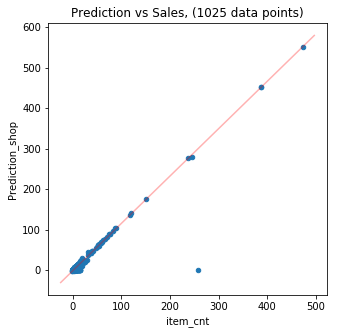

In [40]:
FP_evaluate.plot.scatter(x='item_cnt', y='Prediction_shop', figsize=(5,5), title=('Prediction vs Sales, (%i data points)' % len(df_evaluate)))
plt.plot(xlim(), ylim(), ls="-", c='r', alpha=.3)
plt.show()

Facebook Prophet is very effective in predicting the shop-item sales in September 2015. We will save the model and use it for comparison

In [41]:
# Pickle the dataframe for model comparison
import pickle
pickle.dump(cfg_dict, open('FP_model.pkl','wb'))